In [1]:
include("../LiPoSID.jl")

#include("CtrlSID.jl")


using QuantumOptics
basis = NLevelBasis(2)
using LinearAlgebra

using HDF5
using DynamicPolynomials

using Dates

using Statistics

using TSSOS

┌ Warning: Package LinearSolve does not have KrylovKit in its dependencies:
│ - If you have LinearSolve checked out for development and have
│   added KrylovKit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LinearSolve
└ Loading KrylovKit into LinearSolve from project dependency, future warnings for LinearSolve are suppressed.


In [2]:
function kossak_obj(ρ, t, Hˢʸᵐᵇ, Cˢʸᵐᵇ, Fᴼᴺᴮ)

    function Dc(ρ, t)
        U = (Hˢʸᵐᵇ*ρ - ρ*Hˢʸᵐᵇ)/im 
        D = sum(Cˢʸᵐᵇ .* [2*fᵢ*ρ*fⱼ' - ρ*fⱼ'*fᵢ - fⱼ'*fᵢ*ρ  for fᵢ in Fᴼᴺᴮ, fⱼ in Fᴼᴺᴮ])/2
        return U + D
    end 

    obj = 0
    for i in 3:length(ρ)
        obj += LiPoSID.frobenius_norm2(
            ρ[i] - ρ[i-2] - (t[i]-t[i-1])*(Dc(ρ[i], t[i])+
            4*Dc(ρ[i-1], t[i-1])+Dc(ρ[i-2], t[i-2]))/3
        )
    end

    if isempty(monomials(obj))
        obj = 0. 
    else
        obj = sum(real(coef) * mon for (coef, mon) in zip(coefficients(obj), monomials(obj)))
    end

    return obj

end

function kossak_GEXY_obj(ρᵍᵉˣʸ, tᵍᵉˣʸ, H0ˢʸᵐᵇ, Cˢʸᵐᵇ, fᴼᴺᴮ)

    ρᵍ, ρᵉ, ρˣ, ρʸ = ρᵍᵉˣʸ
    tᵍ, tᵉ, tˣ, tʸ = tᵍᵉˣʸ

    polyG = kossak_obj(ρᵍ, tᵍ, H0ˢʸᵐᵇ, Cˢʸᵐᵇ, fᴼᴺᴮ)
    polyE = kossak_obj(ρᵉ, tᵉ, H0ˢʸᵐᵇ, Cˢʸᵐᵇ, fᴼᴺᴮ)
    polyX = kossak_obj(ρˣ, tˣ, H0ˢʸᵐᵇ, Cˢʸᵐᵇ, fᴼᴺᴮ)
    polyY = kossak_obj(ρʸ, tʸ, H0ˢʸᵐᵇ, Cˢʸᵐᵇ, fᴼᴺᴮ)

    polyGEXY = polyG + polyE + polyX + polyY

    return polyGEXY
end

kossak_GEXY_obj (generic function with 1 method)

### Kossakowski objective for two-level system


For the two level system we can use theorem originally proved by Kossakowski:

Kossakowski, Bull. Acad. Pol. Sci. Ser. Math. Astr. Phys. 21, 649 (1973).

and available also in classic GKS paper:

Completely positive dynamical semigroups of Nlevel systems
Vittorio Gorini, Andrzej Kossakowski, and E. C. G. Sudarshan
Citation: J. Math. Phys. 17, 821 (1976); doi: 10.1063/1.522979

Theorem 3.1. (two-level system)

A linear operator $L: M(2) \rightarrow M(2)$ is the generator of a dynamical semigroup $t \rightarrow \Lambda_t$ of $M(2)$ iff it can be written in the form:

$L = -i[H,\rho] + \frac{1}{2} \sum_{i,j}^3 C_{ij} \{[f_i, \rho f_j] + [f_i\rho, f_j]\}, \quad \rho \in M(2)$

where

(i) $H = \sum_1^3 h_i f_i, \quad h_i \in \R$

(ii) $f_i f_j = \frac{1}{4}\delta_{ij}I  +\frac{i}{2} \sum_{k=1}^3 \epsilon_{ijk} f_k$ which means:

$ \operatorname{tr}(f_i f_j)=\frac{1}{2}\delta_{ij}, \quad \operatorname{tr}(f_i) = 0$


(iii) $\{C_{ij}\}= \begin{pmatrix} 
\gamma - 2\gamma_1    & - i a_3            &  i a_2 \\
i a_3                 & \gamma - 2\gamma_2 & -i a_1 \\
-i a_2                & i a_1              & \gamma - 2\gamma_3 
\end{pmatrix} =$

$=\begin{pmatrix} 
-\gamma_1 + \gamma_2 + \gamma_3   & - i a_3   &  i a_2 \\
i a_3                 & \gamma_1 - \gamma_2 + \gamma_3 & -i a_1 \\
-i a_2                & i a_1      & \gamma_1 + \gamma_2 - \gamma_3 
\end{pmatrix}$

To write a Hamiltonian $H$ and than objective function we can use the set of orthonormal operators $f_j$

We use Pauli matrices $\sigma_x, \sigma_y, \sigma_z$ to choose 3 orthonormal $f_i$ for the two-level system to fulfill:

$f_i f_j = \frac{1}{4}\delta_{ij}I  +\frac{i}{2} \sum_{k=1}^3 \epsilon_{ijk} f_k$ which means:

$ \operatorname{tr}(f_i f_j)=\frac{1}{2}\delta_{ij}, \quad \operatorname{tr}(f_i) = 0$

In [3]:
σˣ = [ 0 1 
       1 0 ]

σʸ = [ 0.   im*1
      -im*1 0    ]

σᶻ = [ 1.  0
       0  -1 ] 

fᴷ₁ = σˣ/2
fᴷ₂ = σʸ/2
fᴷ₃ = σᶻ/2

@assert tr(σˣ/2*σʸ/2) == tr(σˣ/2*σᶻ/2) ==  tr(σʸ/2*σᶻ/2) ≈ 0
@assert tr(σˣ/2*σˣ/2) == tr(σʸ/2*σʸ/2) == tr(σᶻ/2*σᶻ/2) ≈ 1/2

fᴷᴼᴺᴮ = [fᴷ₁, fᴷ₂, fᴷ₃]

3-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.5 + 0.0im; 0.5 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im 0.0 + 0.5im; 0.0 - 0.5im 0.0 + 0.0im]
 [0.5 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.5 + 0.0im]

In [4]:
@polyvar ϵ h_Re h_Im # h₁ h₂ h₃

H0ˢʸᵐᵇ = [ ϵ               h_Re+im*h_Im
           h_Re-im*h_Im   -ϵ            ] / 2

H0ᴷˢʸᵐᵇ = h_Re * fᴷ₁ + h_Im * fᴷ₂  + ϵ * fᴷ₃ 

@assert tr(H0ᴷˢʸᵐᵇ) == 0
@assert H0ᴷˢʸᵐᵇ == H0ˢʸᵐᵇ

Hˢʸᵐᵇ = H0ˢʸᵐᵇ 

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (0.5+0.0im)ϵ                       (0.5+0.0im)h_Re + (0.0+0.5im)h_Im
 (0.5+0.0im)h_Re + (0.0-0.5im)h_Im  (-0.5+0.0im)ϵ

In [5]:
@polyvar m_Re[1:3,1:3]
@polyvar m_Im[1:3,1:3]

M = m_Re + 1.0*im*m_Im

Cˢʸᵐᵇ = M' * M

3×3 Matrix{Polynomial{true, ComplexF64}}:
 m_Re₁₋₁² + m_Re₂₋₁² + m_Re₃₋₁² + m_Im₁₋₁² + m_Im₂₋₁² + m_Im₃₋₁²                                                                                                                                                                                                              …  m_Re₁₋₁m_Re₁₋₃ + (0.0+1.0im)m_Re₁₋₁m_Im₁₋₃ + m_Re₂₋₁m_Re₂₋₃ + (0.0+1.0im)m_Re₂₋₁m_Im₂₋₃ + m_Re₃₋₁m_Re₃₋₃ + (0.0+1.0im)m_Re₃₋₁m_Im₃₋₃ + (0.0-1.0im)m_Re₁₋₃m_Im₁₋₁ + (0.0-1.0im)m_Re₂₋₃m_Im₂₋₁ + (0.0-1.0im)m_Re₃₋₃m_Im₃₋₁ + m_Im₁₋₁m_Im₁₋₃ + m_Im₂₋₁m_Im₂₋₃ + m_Im₃₋₁m_Im₃₋₃
 m_Re₁₋₁m_Re₁₋₂ + (0.0-1.0im)m_Re₁₋₁m_Im₁₋₂ + m_Re₂₋₁m_Re₂₋₂ + (0.0-1.0im)m_Re₂₋₁m_Im₂₋₂ + m_Re₃₋₁m_Re₃₋₂ + (0.0-1.0im)m_Re₃₋₁m_Im₃₋₂ + (0.0+1.0im)m_Re₁₋₂m_Im₁₋₁ + (0.0+1.0im)m_Re₂₋₂m_Im₂₋₁ + (0.0+1.0im)m_Re₃₋₂m_Im₃₋₁ + m_Im₁₋₁m_Im₁₋₂ + m_Im₂₋₁m_Im₂₋₂ + m_Im₃₋₁m_Im₃₋₂     m_Re₁₋₂m_Re₁₋₃ + (0.0+1.0im)m_Re₁₋₂m_Im₁₋₃ + m_Re₂₋₂m_Re₂₋₃ + (0.0+1.0im)m_Re₂₋₂m_Im₂₋₃ + m_Re₃₋₂m_Re₃₋₃ + (0.0+1.0im)m_Re₃₋₂m_Im₃₋₃ + (0.0-1.0i

In [6]:

function read_timeevolution(file_name, state, γ)
    h5open(file_name, "r") do file
        ρᵧ = read(file[state][string(γ)])
        t = ρᵧ["t"]
        ρ₀₀ = ρᵧ["p0"]; Re_ρ₀₁ = ρᵧ["s_re"];  Im_ρ₀₁ = ρᵧ["s_im"]
        ρ_series = []
        t_series = []

        for i in 1:length(t)
            ρᵢ= [ ρ₀₀[i]                      Re_ρ₀₁[i] + im * Im_ρ₀₁[i]
                  Re_ρ₀₁[i] - im * Im_ρ₀₁[i]  1 - ρ₀₀[i]                 ]
            push!(ρ_series, convert(Matrix{ComplexF64}, ρᵢ))
            push!(t_series, convert(Float64, t[i]))
        end
        return(t_series, ρ_series)
    end
end


function read_GEXY_timeevolution(file_name, γ)

    tᵍ, ρᵍ = read_timeevolution(file_name, "B1", γ)
    tᵉ, ρᵉ = read_timeevolution(file_name, "B2", γ)
    tˣ, ρˣ = read_timeevolution(file_name, "B3", γ)
    tʸ, ρʸ = read_timeevolution(file_name, "B4", γ)

    ρᵍᵉˣʸ = ρᵍ, ρᵉ, ρˣ, ρʸ 
    tᵍᵉˣʸ = tᵍ, tᵉ, tˣ, tʸ

    return tᵍᵉˣʸ , ρᵍᵉˣʸ 

end

read_GEXY_timeevolution (generic function with 1 method)

In [7]:
function TrDist(ρ₁, ρ₂)
    A = ρ₁-ρ₂
    D = tr(sqrt(A'*A))/2
    if abs(imag(D))>1e-6
        throw(DomainError(D, "Trace distance is complex number"))
    else
        return(real(D))
    end
end 

TrDist (generic function with 1 method)

In [8]:
function get_lindblad_operators(C, basis_ops)#(C::Matrix{ComplexF64}, basis_ops::Vector{Matrix{ComplexF64}})
    # Check that C is a square matrix and basis_ops has the same dimension
    n = size(C, 1)
    if size(C, 2) != n || length(basis_ops) != n
        throw(ArgumentError("Dimensions of C and basis_ops do not match"))
    end

    # Perform eigenvalue decomposition of C
    eigvals, eigvecs = eigen(C)

    # Construct the Lindblad operators
    lindblad_ops = []
    for i in 1:n
        if eigvals[i] > 1e-10  # Filter out negligible eigenvalues to ensure numerical stability
            lindblad_op = zeros(ComplexF64, size(basis_ops[1]))
            for j in 1:n
                lindblad_op .+= sqrt(eigvals[i]) * eigvecs[j, i] * basis_ops[j]
            end
            push!(lindblad_ops, lindblad_op)
        end
    end

    return lindblad_ops
end

get_lindblad_operators (generic function with 1 method)

In [9]:
#tests_dir = "../TESTS/"
tests_dir = ""

ρᵍ₀ = [ 1 0
        0 0 ]    # state to measure initial distance from

dodeca_10_states = ["D"*string(n) for n=1:10];

basis_states = ["B"*string(n) for n=1:4];

train_states = basis_states 
test_states = dodeca_10_states

all_states = vcat(train_states, test_states);

In [10]:
function filter_terms_by_relative_threshold(poly::Polynomial, relative_threshold::Float64)
    # Get all coefficients of the polynomial
    coeffs = coefficients(poly)
    
    # Find the largest coefficient by absolute value
    max_coeff = maximum(abs.(coeffs))
    
    # Calculate the effective threshold
    threshold = relative_threshold * max_coeff
    
    # Initialize an empty polynomial of the same type as the input
    new_poly = zero(poly)
    
    # Iterate over the terms and coefficients of the polynomial
    for (monomial, coeff) in zip(monomials(poly), coeffs)
        if abs(coeff) >= threshold
            new_poly += coeff * monomial
        end
    end
    
    return new_poly
end

# Example usage
#@polyvar x y
#p = 1e-13*x^2 + 2*x*y + 3*y^2 + 4e-14*y
#relative_threshold = 1e-12
#filtered_p = filter_terms_by_relative_threshold(p, relative_threshold)
#println(filtered_p)

2.0*x*y + 3.0*y^2


In [11]:
evol_data_file_name = "../DATA/ALL_GAMMAS_B4_D10.h5"

γᵢ = "0.25133"

tᵍᵉˣʸ , ρᵍᵉˣʸ  = read_GEXY_timeevolution(evol_data_file_name, γᵢ)
polyGEXYfull = kossak_GEXY_obj(ρᵍᵉˣʸ, tᵍᵉˣʸ, Hˢʸᵐᵇ, Cˢʸᵐᵇ, fᴷᴼᴺᴮ);

In [13]:
maxdegree(polyGEXYfull)

4

In [107]:
using Plots

function plot_coefs(poly)
    # Extract coefficients
    coefs = coefficients(poly)
    
    # Sort coefficients by their absolute value in descending order
    sorted_coefs = sort(abs.(coefs), rev=true)
    
    # Plot the coefficients
    plot(sorted_coefs, 
         yscale=:log10, 
         marker=:circle, 
         xlabel="Coefficient Index", 
         ylabel="Coefficient Value (log scale)", 
         title="Coefficients of the Polynomial", 
         label="Coefficients",
         legend=:bottomleft)

    
    hline!([1e-6], linestyle=:dash, color=:red, label="1e-6")
    hline!([1e-8], linestyle=:dash, color=:orange, label="1e-8")
    hline!([1e-9], linestyle=:dash, color=:green, label="1e-9")
    hline!([1e-12], linestyle=:dash, color=:blue, label="1e-12") 

end

plot_coefs (generic function with 1 method)

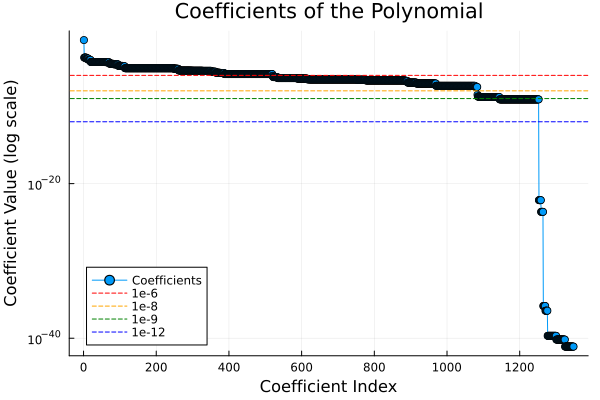

In [108]:
plot_coefs(polyGEXYfull)

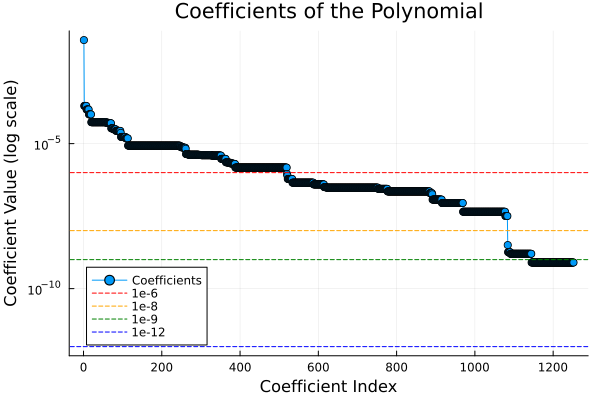

In [109]:
plot_coefs(filter_terms_by_relative_threshold(polyGEXYfull, 1e-12))

In [14]:
using TSSOS

In [76]:
function min_tssos(p)
    
    # Initial optimization step
    opt, sol, data = tssos_first(p, variables(p); solution=true, newton=false, QUIET=true)
    ref_sol, flag = TSSOS.refine_sol(opt, sol, data; QUIET=true)
    prev_opt, prev_sol, prev_data = opt, sol, data 

    # Check if the solution needs further refinement
    if flag != 0
        while ~isnothing(sol) && flag != 0
            prev_opt, prev_sol, prev_data = opt, sol, data
            opt, sol, data = tssos_higher!(data; solution=true, QUIET=true) 
        end
        ref_sol, flag = TSSOS.refine_sol(prev_opt, prev_sol, prev_data; QUIET=true)
    end

    solution = variables(p) => ref_sol

    if flag == 0 
        status_name = "GLOBAL"
    else
        status_name = "LOCAL/FAIL"
    end

    return solution, status_name

end

min_tssos (generic function with 1 method)

In [116]:
regularization = sum(variables(polyGEXYfull).^2)

ϵ² + h_Re² + h_Im² + m_Re₁₋₁² + m_Re₂₋₁² + m_Re₃₋₁² + m_Re₁₋₂² + m_Re₂₋₂² + m_Re₃₋₂² + m_Re₁₋₃² + m_Re₂₋₃² + m_Re₃₋₃² + m_Im₁₋₁² + m_Im₂₋₁² + m_Im₃₋₁² + m_Im₁₋₂² + m_Im₂₋₂² + m_Im₃₋₂² + m_Im₁₋₃² + m_Im₂₋₃² + m_Im₃₋₃²

In [151]:
solut, tssos_status = min_tssos(filter_terms_by_relative_threshold(polyGEXYfull, 1e-6))

*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.0048710042132430326
Global optimality certified with relative optimality gap 0.000148%!
Global optimality certified with relative optimality gap 0.000148%!


(PolyVar{true}[ϵ, h_Re, h_Im, m_Re₁₋₁, m_Re₂₋₁, m_Re₃₋₁, m_Re₁₋₂, m_Re₂₋₂, m_Re₃₋₂, m_Re₁₋₃  …  m_Re₃₋₃, m_Im₁₋₁, m_Im₂₋₁, m_Im₃₋₁, m_Im₁₋₂, m_Im₂₋₂, m_Im₃₋₂, m_Im₁₋₃, m_Im₂₋₃, m_Im₃₋₃] => [13.263412340448498, 3.5265438078805316, -0.5444763577873708, 9.5799529192735, 9.57995291948925, 9.579952919079416, 0.2612729129040917, 0.2612729103514131, 0.2612729160720418, -0.028782903916219654  …  -0.028782906139879466, 7.1028696275794525, 7.102869627632379, 7.102869627603649, 0.6327962963470781, 0.6327962935913631, 0.6327962977170637, 0.00044297095141706053, 0.00044296930480521604, 0.0004429735852024617], "GLOBAL")

In [152]:
tssos_status

"GLOBAL"

In [153]:
Cˢⁱᵈ = convert.(ComplexF64,subs(Cˢʸᵐᵇ, solut))
Cˢⁱᵈ[1:2,1:2]

2×2 Matrix{ComplexF64}:
 426.679+0.0im       20.993+12.6191im
  20.993-12.6191im  1.40608+0.0im

In [41]:
Cˢⁱᵈ = convert.(ComplexF64,subs(Cˢʸᵐᵇ, solut))
Cˢⁱᵈ[1:2,1:2]

2×2 Matrix{ComplexF64}:
   0.243452+0.0im      0.00272268+0.24485im
 0.00272268-0.24485im    0.246287+0.0im

In [42]:
Hˢⁱᵈ = convert.(ComplexF64, subs(Hˢʸᵐᵇ, solut))

2×2 Matrix{ComplexF64}:
    12.5703+0.0im        -0.0179358-0.0267618im
 -0.0179358+0.0267618im    -12.5703+0.0im

In [155]:
println(" SYSTEM IDENTIFICATION w UNCONSTRAINED TSSOS and KOSSAKOWSKI Frobenius objective QO simulation")

γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

date_and_time_string =  string(Dates.format(now(), "yyyy-u-dd_at_HH-MM"))

evol_data_file_name = "../DATA/ALL_GAMMAS_B4_D10.h5"

relative_threshold = 1e-9

rltrs = string(convert(Int, floor(log10(relative_threshold))))

tests_data_file_name = "POP_NEW_TSSOS_KOS_treshold_1e"*rltrs*"_FROB_QO_"*date_and_time_string * ".h5"

FminGammas = []
FmedianGammas = []
FmeanGammas = []
Epsilons = []

for γᵢ in γ

    println("γ =  "*γᵢ)

    tᵍᵉˣʸ , ρᵍᵉˣʸ  = read_GEXY_timeevolution(evol_data_file_name, γᵢ)
    polyGEXYfull = kossak_GEXY_obj(ρᵍᵉˣʸ, tᵍᵉˣʸ, Hˢʸᵐᵇ, Cˢʸᵐᵇ, fᴷᴼᴺᴮ)

    @show minimum(abs.(coefficients(polyGEXYfull)))
    @show maximum(abs.(coefficients(polyGEXYfull)))

    polyGEXY = filter_terms_by_relative_threshold(polyGEXYfull, relative_threshold)

    @show minimum(abs.(coefficients(polyGEXY)))
    @show maximum(abs.(coefficients(polyGEXY)))

    sol, status = min_tssos(polyGEXY)
    
    print(" status:", status)

    Hˢⁱᵈ = convert.(ComplexF64, subs(Hˢʸᵐᵇ, sol))
    Cˢⁱᵈ = convert.(ComplexF64,subs(Cˢʸᵐᵇ, sol))
    epsilon = subs(ϵ, sol)

    push!(Epsilons, epsilon)
    
    h5open(tests_dir*tests_data_file_name,"cw") do fid
        γ_group = create_group(fid, γᵢ) # create gamma coupling group   
        γ_group["epsilon"] = convert(Float64, epsilon)
        γ_group["H"] = convert.(ComplexF64, Hˢⁱᵈ)
        γ_group["C"] = convert.(ComplexF64, Cˢⁱᵈ)
        γ_group["status"] = status

    end

    println()

    FminStates = []
    FmedianStates = []
    FmeanStates = []

    for state in test_states # loop over initial states
        
        print(state*" ")

        start_time = time()

        tₛ, ρₛ = read_timeevolution(evol_data_file_name, state, γᵢ)
        ρₛ = convert(Vector{Matrix{ComplexF64}}, ρₛ)
        #bᵗˢᵗ = LiPoSID.bloch(ρₛ)
        ρᵗˢᵗ = [DenseOperator(basis,Hermitian(ρₜ)) for ρₜ in ρₛ]
        tᵗˢᵗ = convert(Vector{Float64}, tₛ)

        ρₒ = DenseOperator(basis, ρₛ[1])
        dt = tᵗˢᵗ[2] - tᵗˢᵗ[1]
        tᵉⁿᵈ = tᵗˢᵗ[end]

        #print("effective_Lindblad_ops for Kossakowski")

        effective_Lindblad = get_lindblad_operators(convert.(ComplexF64, Cˢⁱᵈ), fᴷᴼᴺᴮ)
        effective_Lindblad_ops = [DenseOperator(basis,j) for j in effective_Lindblad]

        #print("Simulating Kossakowski")

        tout, ρ_t_kossak = timeevolution.master(convert.(Float64, tᵗˢᵗ), ρₒ, DenseOperator(basis, Hˢⁱᵈ), effective_Lindblad_ops)
        ρˢⁱᵈ  = [ρₜ.data for ρₜ in ρ_t_kossak]

        #bˢⁱᵈ = LiPoSID.bloch(ρˢⁱᵈ)

        F = LiPoSID.fidelity_series(basis, ρₛ, ρˢⁱᵈ)

        #Fᴸᴹᴱₑₓ = [abs(fidelity(ρ₁, ρ₂)) for (ρ₁, ρ₂) in zip(ρᵗˢᵗ, ρˢⁱᵈ)]   

        h5open(tests_dir*tests_data_file_name,"cw") do fid
            γ_group = open_group(fid, γᵢ) # open gamma coupling group
            init_state_group = create_group(γ_group, state) # create initial state group
            init_state_group["Fidelity"] = convert.(Float64, F)
            #init_state_group["bloch_exact"] = convert.(Float64, bᵗˢᵗ)
            #init_state_group["bloch_sid"] = convert.(Float64, bˢⁱᵈ)
            init_state_group["tr_dist_grnd"] = TrDist(ρₛ[1], ρᵍ₀)
            init_state_group["time"] = tᵗˢᵗ
        end
        
        FminState = minimum(F)
        FmedianState = mean(F)
        FmeanState = mean(F)
        
        push!(FminStates, FminState)
        push!(FmedianStates, FmedianState)
        push!(FmeanStates, FmeanState)
    
    end

    # Calculate the mean
    F_mean_value = mean(FmeanStates)

    # Calculate the median
    F_median_value = median(FmedianStates)

    # Calculate the min
    F_min_value = minimum(FminStates)

    push!(FminGammas, F_min_value)
    push!(FmedianGammas, F_median_value)
    push!(FmeanGammas, F_mean_value)

    println("Median fidelity for "*γᵢ*": ", F_median_value)

end

h5open(tests_dir*tests_data_file_name,"cw") do fid
    fid["F_min"] = convert.(Float64,FminGammas)
    fid["F_median"] = convert.(Float64,FmedianGammas)
    fid["F_mean"] = convert.(Float64,FmeanGammas)
    fid["Energy"] = convert.(Float64,Epsilons)
end


println(tests_data_file_name)

 SYSTEM IDENTIFICATION w UNCONSTRAINED TSSOS and KOSSAKOWSKI Frobenius objective QO simulation
γ =  0.079477
minimum(abs.(coefficients(polyGEXYfull))) = 7.16715101396591e-37
maximum(abs.(coefficients(polyGEXYfull))) = 501.8627949039175
minimum(abs.(coefficients(polyGEXY))) = 2.679249890878951e-5
maximum(abs.(coefficients(polyGEXY))) = 501.8627949039175
*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.0005511044706349094
The local solver failed refining the solution!
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!
The local solver failed refining the solution!
 status:LOCAL/FAIL
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.079477: 0.9318550336119773
γ =  0.25133
minimum(abs.(coefficients(polyGEXYfull))) = 4.658513032068184e-37
maximum(abs.(coefficients(polyGEXYfull))) = 65.37495321955478
minimum(abs.(coefficients(polyGEXY))) = 8.62938832375385e-6
maximum(abs.(coefficients(poly

 SYSTEM IDENTIFICATION w CONSTRAINED TSSOS and KOSSAKOWSKI objective QO simulation
γ =  0.079477
minimum(abs.(coefficients(polyGEXY))) = 0.00010716999563516075
maximum(abs.(coefficients(polyGEXY))) = 501.8627949039175
 status:Local
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.079477: 0.9976226185525447
γ =  0.25133
minimum(abs.(coefficients(polyGEXY))) = 3.45175532950157e-5
maximum(abs.(coefficients(polyGEXY))) = 65.37495321955478
 status:Local
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.25133: 0.996633883661821
γ =  0.79477
minimum(abs.(coefficients(polyGEXY))) = 2.1434036477811963e-6
maximum(abs.(coefficients(polyGEXY))) = 7.630493479021682
 status:Local
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 0.79477: 0.997693174205029
γ =  2.5133
minimum(abs.(coefficients(polyGEXY))) = 1.780563581016409e-7
maximum(abs.(coefficients(polyGEXY))) = 1.121995426822635
 status:Local
D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 Median fidelity for 2.5133: 0.9990491303024693
γ =  7.9477
minim

In [79]:
println(tests_data_file_name)

POP_NEW_TSSOS_KOS_treshold_1e-4_FROB_QO_2024-Aug-08_at_13-42.h5
